# Social Media Ads Sales Forecasting

Objectives: Sales forecasts based on social media platforms, and suggest budget allocation given $100k budget

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Obtaining the Data

In [2]:
df = pd.read_excel('social-ads-raw.xlsx')
df.sample(5)

,segment,google,facebook,instagram,sales,size,area
159,160,131.7,18.4,34.6,12.9,large,urban
60,61,53.5,2.0,21.4,8.1,small,suburban
117,118,76.4,0.8,14.8,9.4,large,urban
114,115,78.2,46.8,34.5,14.6,small,urban
180,181,156.6,2.6,8.3,10.5,small,urban


## Scrub Data

In [3]:
categorical_columns = df.loc[:,['size', 'area']].columns.tolist()

# print frequency of categories
for col in categorical_columns:
    print ('\nFrequency of variable: %s'%col)
    print (df[col].value_counts())


Frequency of variable: size
large    108
small     92
Name: size, dtype: int64

Frequency of variable: area
suburban    78
urban       63
rural       59
Name: area, dtype: int64


In [5]:
# Creating new column and converting 'size' to binary

df['islarge'] = df['size'].map({'small': 0, 'large': 1})

In [6]:
df2 = pd.get_dummies(df, prefix={'area':'area'}, columns=['area'])
df3 = df2.drop(['size'], axis=1)
df3.head()

,segment,google,facebook,instagram,sales,islarge,area_rural,area_suburban,area_urban
0,1,230.1,37.8,69.2,22.1,1,1,0,0
1,2,44.5,39.3,45.1,10.4,0,0,0,1
2,3,17.2,45.9,69.3,9.3,0,1,0,0
3,4,151.5,41.3,58.5,18.5,0,0,0,1
4,5,180.8,10.8,58.4,12.9,1,0,1,0


In [7]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   segment        200 non-null    int64  
 1   google         200 non-null    float64
 2   facebook       200 non-null    float64
 3   instagram      200 non-null    float64
 4   sales          200 non-null    float64
 5   islarge        200 non-null    int64  
 6   area_rural     200 non-null    uint8  
 7   area_suburban  200 non-null    uint8  
 8   area_urban     200 non-null    uint8  
dtypes: float64(4), int64(2), uint8(3)
memory usage: 10.1 KB


## Explore Data

### Heatmap

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_14212/3958557817.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


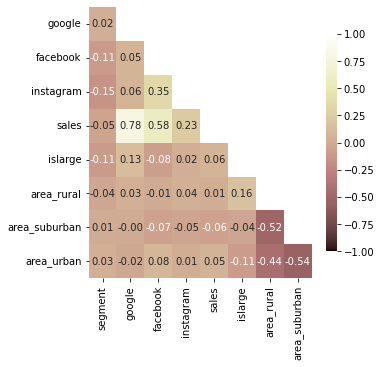

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))

corr = df3.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

mask = mask[1:, :-1]
corr = corr.iloc[1:,:-1].copy()

sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="pink", vmin=-1, vmax=1, cbar_kws={"shrink": .8})
plt.show()

Text(0.5, 1.0, 'Correlation with Sales')

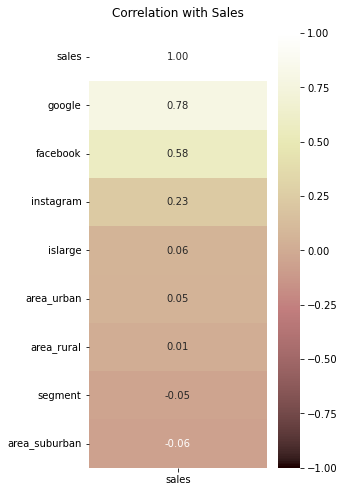

In [9]:
plt.figure(figsize=(4, 8))
heatmap = sns.heatmap(df3.corr()[['sales']].sort_values(by='sales', ascending=False), vmin=-1, vmax=1, annot=True, cmap='pink',fmt=".2f")
heatmap.set_title('Correlation with Sales', fontdict={'fontsize':12}, pad=16)

### Regplot and Histogram

<AxesSubplot:ylabel='Frequency'>

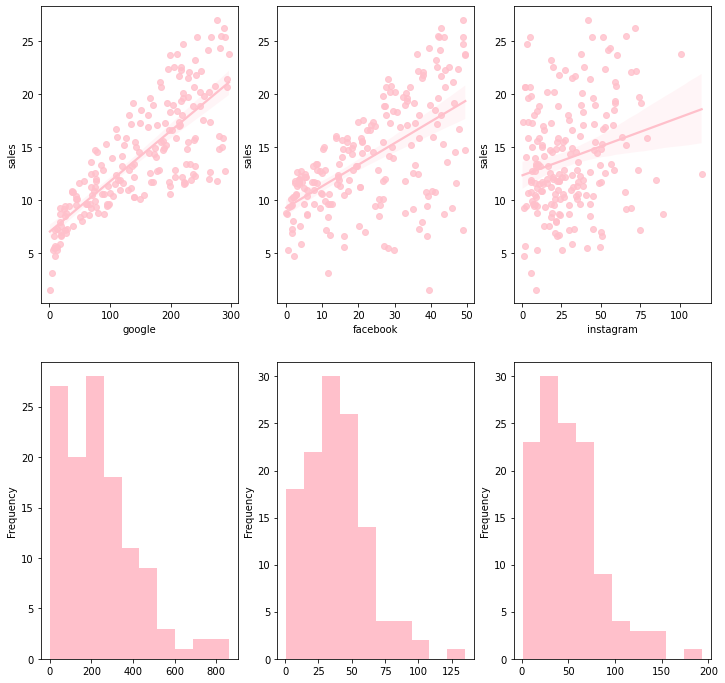

In [10]:
fig, subs = plt.subplots(2, 3, figsize=(12,12))

sns.regplot(data=df3, x="google", y="sales", color="pink", ax=subs[0,0])
sns.regplot(data=df3, x="facebook", y="sales", color="pink", ax=subs[0,1])
sns.regplot(data=df3, x="instagram", y="sales", color="pink", ax=subs[0,2])

gg = df3.groupby(['sales'])['google'].sum().reset_index()
fb = df3.groupby(['sales'])['facebook'].sum().reset_index()
ig = df3.groupby(['sales'])['instagram'].sum().reset_index()

gg['google'].plot(kind='hist', color="pink", ax=subs[1,0])
fb['facebook'].plot(kind='hist', color="pink", ax=subs[1,1])
ig['instagram'].plot(kind='hist', color="pink", ax=subs[1,2])

- The greater the magnitude of the slope, the steeper the line, the greater the rate of change
- Google >>> Facebook >>> Instagram

In [11]:
Google = df3['google'].sum() / df3['sales'].sum()
Facebook = df3['facebook'].sum() / df3['sales'].sum()
Instagram = df3['instagram'].sum() / df3['sales'].sum()

print("Google ads spent per unit sold:", f"{Google:.2f}")
print("Facebook ads spent per unit sold:", f"{Facebook:.2f}")
print("Instagram ads spent per unit sold:", f"{Instagram:.2f}")

Google ads spent per unit sold: 10.49
Facebook ads spent per unit sold: 1.66
Instagram ads spent per unit sold: 2.18


Costs in ads spent in order to sell a unit:

- Google is most expensive with $10.49, followed by Instagram and Facebook
- Google >>> Instagram >>> Facebook

### Simple Linear Regression

Comparison between performance of Google / Facebook / Instagram

In [12]:
from sklearn.linear_model import LinearRegression
y = df3['sales']

In [13]:
X1 = df3[['google']]
X2 = df3[['facebook']]
X3 = df3[['instagram']]

X = [X1, X2, X3]

# predict_value
n = 100

unit_price = 5000

for i in range(3):
    reg = LinearRegression()
    reg.fit(X[i].values, y)
    R2 = reg.score(X[i].values, y)
    predict = reg.predict([[n]])
    revenue = predict[0] * 1000 * unit_price

    if i == 0:
       print("\n Google")
       print("R-square:", "{:.2%}".format(R2))
       print("Intercept:", "{:.4f}".format(reg.intercept_))
       print("Coefficient:", "{:.4f}".format(reg.coef_[0]))
       print("Every", n, "thousand amount spent in ads yields", "{:.2f}".format(predict[0]), "thousand units sold")
       print("Total Revenue:", "${:,.0f}".format(revenue))
    elif i == 1:
       print("\n Facebook")
       print("R-square:", "{:.2%}".format(R2))
       print("Intercept:", "{:.4f}".format(reg.intercept_))
       print("Coefficient:", "{:.4f}".format(reg.coef_[0]))
       print("Every", n, "thousand amount spent in ads yields", "{:.2f}".format(predict[0]), "thousand units sold")
       print("Total Revenue:", "${:,.0f}".format(revenue))
    elif i == 2:
       print("\n Instagram")
       print("R-square:", "{:.2%}".format(R2))
       print("Intercept:", "{:.4f}".format(reg.intercept_))
       print("Coefficient:", "{:.4f}".format(reg.coef_[0]))
       print("Every", n, "thousand amount spent in ads yields", "{:.2f}".format(predict[0]), "thousand units sold")
       print("Total Revenue:", "${:,.0f}".format(revenue))


 Google
R-square: 61.19%
Intercept: 7.0326
Coefficient: 0.0475
Every 100 thousand amount spent in ads yields 11.79 thousand units sold
Total Revenue: $58,931,288

 Facebook
R-square: 33.20%
Intercept: 9.3116
Coefficient: 0.2025
Every 100 thousand amount spent in ads yields 29.56 thousand units sold
Total Revenue: $147,806,082

 Instagram
R-square: 5.21%
Intercept: 12.3514
Coefficient: 0.0547
Every 100 thousand amount spent in ads yields 17.82 thousand units sold
Total Revenue: $89,103,585


- Google R-square > 60% indicates a better fit for the model 
- With the same amount spent in ads, sales generating follow by: Facebook >>> Instagram >>> Google

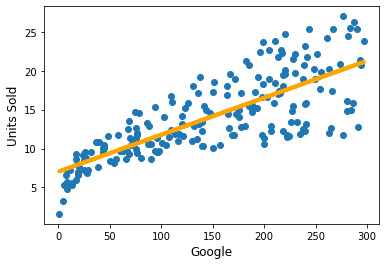

In [14]:
plt.scatter(X1, y)
yhat = 0.0475 * X1 + 7.0326
fig = plt.plot(X1, yhat, lw=4, c='orange', label='regression line')
plt.xlabel('Google', fontsize=12)
plt.ylabel('Units Sold', fontsize=12)
plt.show()

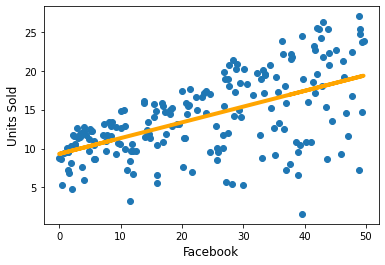

In [15]:
plt.scatter(X2, y)
yhat = 0.2025 * X2 + 9.3116
fig = plt.plot(X2, yhat, lw=4, c='orange', label='regression line')
plt.xlabel('Facebook', fontsize=12)
plt.ylabel('Units Sold', fontsize=12)
plt.show()

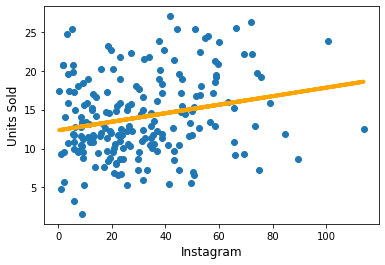

In [16]:
plt.scatter(X3, y)
yhat = 0.0547 * X3 + 12.3514
fig = plt.plot(X3, yhat, lw=4, c='orange', label='regression line')
plt.xlabel('Instagram', fontsize=12)
plt.ylabel('Units Sold', fontsize=12)
plt.show()

### Multiple Linear Regression

Overall Model

In [17]:
selected_feat = ['facebook', 'instagram', 'google', 'islarge', 'area_urban', 'area_suburban', 'area_rural']
X = df3[selected_feat].values

model = LinearRegression()
model.fit(X, y)
R2 = model.score(X, y)
print("R-square:", "{:.2%}".format(R2))

R-square: 89.82%


In [18]:
summary_table = pd.DataFrame(columns=['Features'], data=selected_feat)
summary_table['Coefficient'] = np.transpose(model.coef_)
summary_table['Intercept'] = model.intercept_
summary_table

,Features,Coefficient,Intercept
0,facebook,0.187867,2.928049
1,instagram,-0.001088,2.928049
2,google,0.045744,2.928049
3,islarge,0.077397,2.928049
4,area_urban,0.214280,2.928049
5,area_suburban,-0.160421,2.928049
6,area_rural,-0.053858,2.928049


In [19]:
summary_table['Odds_Ratio'] = np.exp(summary_table.Coefficient)
summary_table.sort_values('Odds_Ratio', ascending=False)

,Features,Coefficient,Intercept,Odds_Ratio
4,area_urban,0.214280,2.928049,1.238969
0,facebook,0.187867,2.928049,1.206673
3,islarge,0.077397,2.928049,1.080471
2,google,0.045744,2.928049,1.046806
1,instagram,-0.001088,2.928049,0.998913
6,area_rural,-0.053858,2.928049,0.947566
5,area_suburban,-0.160421,2.928049,0.851785


- Instagram has a negative coefficient towards units sold, which is not effective in generating revenues
- Google is most expensive and less effective compared with Facebook
- Facebook is most effective and cheaper compared with Google

In [20]:
model.predict([[30, 20, 50, 0, 1, 0, 0]])

array([11.04377644])

## Sales Simulation

Given budget $100,000, how would you allocate your budget to maximize revenue?

In [24]:
# Budget $100k

import random
gg_rd = list(random.sample(range(0, 100, 1), 100))

fb_rd = []
for i in range(len(gg_rd)):
    fb_rd.append(random.randrange(0, 100-gg_rd[i], 1))

In [25]:
rd_df = pd.DataFrame(gg_rd)
rd_df.rename(columns={0: 'google'}, inplace=True)

rd_df1 = pd.DataFrame(fb_rd)
rd_df1.rename(columns={0: 'facebook'}, inplace=True)

rd_df2 = rd_df.join(rd_df1)
rd_df2['instagram'] = 100-rd_df2[['google', 'facebook']].sum(1).astype(int)

rd_df2['islarge'] = 1
rd_df2['area_urban'] = 1
rd_df2['area_suburban'] = 0
rd_df2['area_rural'] = 0

newdf = rd_df2[['facebook', 'instagram', 'google', 'islarge', 'area_urban', 'area_suburban', 'area_rural']]

In [26]:
# Prediction revenue and allocation
unit_price = 5000

y_head = model.predict(newdf)
predictdf = pd.DataFrame({'Expected_Units_Sold': y_head})

newdf2 = newdf.join(predictdf)
newdf2['Expected_Revenue'] = newdf2['Expected_Units_Sold'] * 1000 * unit_price

sorted_df = newdf2.sort_values(by=['Expected_Revenue'], ascending=False)
sorted_df.style.format({'Expected_Units_Sold': "{:,.2f}", 'Expected_Revenue': "$ {:,.0f}"})

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


,facebook,instagram,google,islarge,area_urban,area_suburban,area_rural,Expected_Units_Sold,Expected_Revenue
28,94,2,4,1,1,0,0,21.06,"$ 105,299,978"
65,94,6,0,1,1,0,0,20.87,"$ 104,363,344"
30,90,1,9,1,1,0,0,20.54,"$ 102,691,683"
8,91,6,3,1,1,0,0,20.45,"$ 102,231,504"
71,87,5,8,1,1,0,0,19.92,"$ 99,623,209"
22,68,8,24,1,1,0,0,17.08,"$ 85,419,078"
63,64,1,35,1,1,0,0,16.84,"$ 84,215,734"
27,68,14,18,1,1,0,0,16.80,"$ 84,014,127"
82,67,22,11,1,1,0,0,16.29,"$ 81,430,245"
66,64,13,23,1,1,0,0,16.28,"$ 81,405,831"


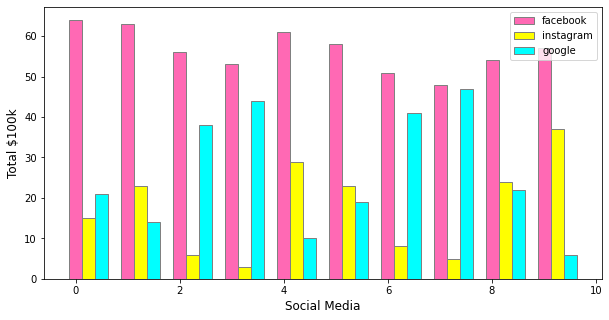

In [27]:
temp = sorted_df[10:20]

barWidth = 0.25
fig = plt.subplots(figsize=(10, 5))

fb = temp['facebook']
ig = temp['instagram']
gg = temp['google']

br1 = np.arange(len(fb))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

plt.bar(br1, fb, color='hotpink', width=barWidth, edgecolor='grey', label='facebook')
plt.bar(br2, ig, color='yellow', width=barWidth, edgecolor='grey', label='instagram')
plt.bar(br3, gg, color='cyan', width=barWidth, edgecolor='grey', label='google')

plt.xlabel('Social Media', fontsize=12)
plt.ylabel('Total $100k', fontsize=12)

plt.legend()
plt.show()